## Import modules

In [25]:
import numpy as np
import open3d as o3d
from sklearn.ensemble import RandomForestClassifier
import pdal
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plyfile import PlyData, PlyElement
import gc
from itertools import chain
from sklearn.metrics import confusion_matrix
import gc
import joblib # Use to save model
from datetime import datetime, timezone
sns.set()

In [2]:
# ROOT_PLY = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/L001.ply"""

## Load in features

In [3]:
ROOT  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_23T22_14_L001_r_0_1_grid_0_02_features.npz"""
ROOT_2  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_23T23_39_L001_r_0_2_grid_0_04_features.npz"""
ROOT_3  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_24T05_30_L001_r_0_4_grid_0_08_features.npz"""
ROOT_4  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_24T11_50_L001_r_0_8_grid_0_16_features.npz"""
ROOT_5  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_24T12_27_L001_r_1_6_grid_0_32_features.npz"""
ROOT_6 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_24T20_28_L001_r_3_2_grid_0_64_features.npz"""
# ROOT_7 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_28T00_29_L001_r_6_4_grid_1_28_features.npz"""
# ROOT_8 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_28T01_37_L001_r_12_8_grid_2_56_features.npz"""


In [4]:
fileList = [ROOT,ROOT_2, ROOT_3,ROOT_4,ROOT_5, ROOT_6]

## Get computed features

In [5]:
das = [np.load(r)["array2"] for r in fileList]
das = np.hstack(das)

## Load in points and labels

In [6]:
xyz = np.load(fileList[0])["array1"]

cls = np.load(fileList[0])["array3"]

## Combine road markings with Ground points

In [7]:
cls[cls==2] = 1

In [8]:
cls[cls > 1] -= 1

## Get columns

In [9]:
cols = ["EigenSum","omnivariance","entropy","linearity","planarity","sphericity","curvature","verticality1","verticality2","count"]

In [10]:
# cols1 = [f"""{a}_radius1""" for a in cols]
# cols2 = [f"""{a}_radius2""" for a in cols]
ff = []

for i in range(1, len(fileList) + 1):
    col = [f"""{a}_radius{i}""" for a in cols]
    ff += col
    

# allCols = cols1 + cols2
    
    
    

In [11]:
allCols = ['X', 'Y','Z'] + ff + ['label']

In [12]:
allAtrs = np.hstack((xyz,das, cls.reshape(-1, 1)))

## Create dataframe

In [13]:
total_dataframe = pd.DataFrame(allAtrs, columns=allCols)
total_dataframe["label"] = total_dataframe["label"].astype(int)
for i in range(1, len(fileList) + 1):
    total_dataframe[f"""count_radius{i}"""] = total_dataframe[f"""count_radius{i}"""].astype(int)
# total_dataframe["count_radius1"] = total_dataframe["count_radius1"].astype(int)
# total_dataframe["count_radius2"] = total_dataframe["count_radius2"].astype(int)

# total_dataframe["labelName"] = total_dataframe["label"].apply(labelPoints)

In [14]:
gc.collect()

108

In [15]:
# ss = ss[ss["count"] > 10]

## Create PLY files with features (Only do if they don't already exist)

In [16]:
# for i in range(1, 7):
#     ls = [col for col in list(total_dataframe) if col.endswith(f"""radius{i}""")]
#     ls = ['X','Y','Z'] + ls + ['label']
#     partial_df = total_dataframe[ls]

#     tpsOut = []
#     for idx, tpe in partial_df.dtypes.to_dict().items():
#         if tpe == 'int64':
#             tpsOut.append((idx, 'i4'))
#         elif tpe == 'float64':
#             tpsOut.append((idx, 'f8'))
            
#     vertex_data = np.empty(allAtrs.shape[0], dtype=tpsOut)
    
#     for t in tpsOut:
#         vertex_data[t[0]] = partial_df[t[0]].values
    
        
#     el = PlyElement.describe(vertex_data, 'vertex')
    
#     # Create a PlyData object and write to a PLY file
#     # Set text=True for ASCII PLY, or text=False for binary PLY
#     PlyData([el], text=False).write(f"""/home/sspiegel/CapstoneData/Paris/Toronto_3D/PC_with_features/L001_features_radius{i}.ply""")

## Instantiate Random Forest classifier

In [17]:
rf = RandomForestClassifier(verbose=1, n_jobs=8)

In [18]:
rf

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
total_dataframe.reset_index(inplace = True)

### Take random samples of labels for training data

In [20]:
maxAcc = 0.0

AccList = [maxAcc]

AccDelta = 1e-4

difDelta = np.inf


randomState = 123
sampleSize = 1000

iters = 0


idsTrained = []

RemainTest = total_dataframe.copy()

while (difDelta >= AccDelta) and ( iters < 50):
    # print(sampleSize)
    print("""Starting iteration %d...""" % (iters + 1))
    TrainList = []
    idsList = []

    for i in range(0,8):
    #     if iters > 0: # Change sampling size after initial sample is given
    #         sampleSize = 1000
        print(f"""Label {i}""")
        SelectList = RemainTest.loc[RemainTest["label"] == i]
        SelectList = SelectList.copy()
        trns = SelectList.sample(n = sampleSize, random_state = randomState)
        idsList.append(trns.index.to_list())
        
        TrainList.append(trns)
    idsList = list(chain.from_iterable(idsList))
    idsTrained += idsList

    TrainList = total_dataframe.loc[idsTrained]

    # TrainList = pd.concat(TrainList)
    
    TrainList = TrainList.sample(frac = 1., random_state = randomState)
    
    TrainListX = TrainList[ff]
    TrainListY = TrainList["label"]
        
    rf.fit(TrainListX, TrainListY)
    
        
    RemainTestX = RemainTest[ff]
    RemainTestY = RemainTest["label"]
    
    RemainTest = RemainTest.loc[~RemainTest["index"].isin(idsTrained)]
    
    
    yPred = rf.predict(RemainTestX)
        
    RemainTestSample = RemainTest.sample(frac = 0.1, random_state=randomState)
    RemainTestSampleX = RemainTestSample[ff]
    RemainTestSampleY = RemainTestSample["label"]
    
    yPredSample = rf.predict(RemainTestSampleX)
    acc = (yPredSample==RemainTestSampleY).sum() / RemainTestSampleY.shape[0]

    print("""Current accuracy: %.4f""" % (100*acc))
    AccList.append(acc)

    difDelta = np.abs(maxAcc - acc)

    print("""\n\nCurrent accuracy delta: %.5f""" % difDelta)
    
    if acc > maxAcc:
        maxAcc = acc
    

    iters += 1

    # idsTrained += idsList  
    gc.collect()

print("""DONE!!!!""")   

    
    
    
    
    # print(total_dataframe.loc[total_dataframe["label"] == i].shape[0])

Starting iteration 1...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.7s finished


Current accuracy: 93.1675


Current accuracy delta: 0.93168
Starting iteration 2...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   39.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.0s finished


Current accuracy: 94.1490


Current accuracy delta: 0.00981
Starting iteration 3...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   40.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.3s finished


Current accuracy: 94.7231


Current accuracy delta: 0.00574
Starting iteration 4...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   41.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.4s finished


Current accuracy: 95.0589


Current accuracy delta: 0.00336
Starting iteration 5...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   42.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.5s finished


Current accuracy: 95.3193


Current accuracy delta: 0.00260
Starting iteration 6...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   43.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.8s finished


Current accuracy: 95.4966


Current accuracy delta: 0.00177
Starting iteration 7...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   44.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.8s finished


Current accuracy: 95.6601


Current accuracy delta: 0.00163
Starting iteration 8...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   45.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.9s finished


Current accuracy: 95.7872


Current accuracy delta: 0.00127
Starting iteration 9...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   45.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.1s finished


Current accuracy: 95.9744


Current accuracy delta: 0.00187
Starting iteration 10...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   45.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.1s finished


Current accuracy: 96.0951


Current accuracy delta: 0.00121
Starting iteration 11...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   46.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.3s finished


Current accuracy: 96.1464


Current accuracy delta: 0.00051
Starting iteration 12...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   16.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   19.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   49.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.6s finished


Current accuracy: 96.2399


Current accuracy delta: 0.00094
Starting iteration 13...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   17.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   45.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.2s finished


Current accuracy: 96.2768


Current accuracy delta: 0.00037
Starting iteration 14...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   19.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   46.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished


Current accuracy: 96.3612


Current accuracy delta: 0.00084
Starting iteration 15...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   21.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   47.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.3s finished


Current accuracy: 96.4378


Current accuracy delta: 0.00077
Starting iteration 16...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   22.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   47.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished


Current accuracy: 96.4659


Current accuracy delta: 0.00028
Starting iteration 17...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   24.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   48.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished


Current accuracy: 96.5289


Current accuracy delta: 0.00063
Starting iteration 18...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   25.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   48.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished


Current accuracy: 96.6059


Current accuracy delta: 0.00077
Starting iteration 19...
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   27.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   49.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.6s finished


Current accuracy: 96.6051


Current accuracy delta: 0.00001
DONE!!!!


In [21]:
gc.collect()

0

## Plot iterations and accuracy

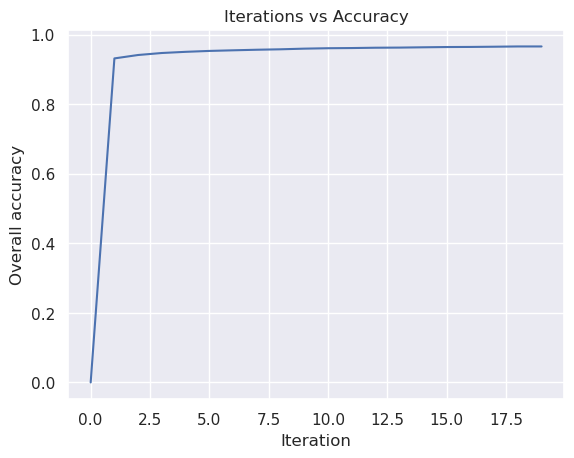

In [23]:
plt.plot(AccList)

plt.xlabel("Iteration")
plt.ylabel("Overall accuracy")

plt.title("Iterations vs Accuracy")

plt.show()


## Output model

In [27]:
OUTS = f"""{datetime.now(timezone.utc).strftime("%Y_%m_%dT%H_%M")}_L001Trained_RF.joblib"""

joblib.dump(rf, f"""/home/sspiegel/CapstoneData/Paris/RF_models/{OUTS}""")

['/home/sspiegel/CapstoneData/Paris/RF_models/2025_10_29T18_36_L001Trained_RF.joblib']